#TP4

Paulo Freitas - A100053


Pedro Santos - A100110

### Enunciado

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    
  - A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`.
    - o modo `Start` inicia o funcionamento com os valores iniciais das velocidades
    - no modo `Free`  não existe qualquer força de travagem;
    - no modo `Stopping` aplica-se a força de travagem alta;
    - no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  move-se (i.e. derrapa) com pequeno atrito ao solo;
    - no modo `Stopped` o veículo está imobilizado.
  - A componente contínua  do autómato usa variáveis contínuas $$\,V,v\,$$ para descrever a  `velocidade do corpo`   e a `velocidade linear das rodas`  ambas em relação so solo.
  - Assume-se que o sistema de travagem exerce uma força de atrito proporcional à diferença das duas velocidades.  A dinâmica contínua, as equações de fluxo, está descrita  abaixo.
  - Os “switchs” são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser  de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.
  - É imprescindível evitar que o sistema tenha “trajetórias de Zenão”. Isto é, sequências  infinitas de transições  entre dois modos em intervalos de tempo  que tendem para zero mas nunca alcançam zero.

Faça

1. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos.
2. A condição de segurança estabelece que o sistema não permaneça no modo `free`  ou no modo `blocked` mais do que $$\,\tau\,$$ segundos.
3. Defina um SFOTS que modele a discretização do autómato híbrido.
4. Verifique nesse modelo
    1. Que as condições de segurança são invariantes do sistema
    2. Que o sistema atinge o estado `stopped` eventualmente.



![](https://paper-attachments.dropboxusercontent.com/s_9896551CC5FAD2B2EB6E4EBC08522545FA66314D29FE6A5BE8E593259F8E8A37_1672830059198_ABS.png)

![](https://paper-attachments.dropboxusercontent.com/s_C5426E33053EA04D1E3446B871CC8485C43045FF7CAAA1FC86A9B3A8E09058F9_1574702123197_Documento.png)



  | Equações de Fluxo

  1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. <br>
  
  2. No contacto rodas/solo a força de compressão é dada pelo o peso $P$ que é constante e independente do modo. Tem-se $f = a\, P$ sendo  $a$ a constante de atrito; o valor de $a$ depende do modo: é baixa em `Blocked` e alta nos restantes.<br>
  
  3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades<br><br>                                                                      $F =  c\, (V-v)$<br>      A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.<br><br>
  
  4. As  equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,<br>                                                        $(\dot{V} \,=\, -F)\,\land\, (\dot{v} \,=\, -a\, P  + F)$   <br>e , no modo `Blocked`,  a dinâmica do sistema é  regida por:<br>                                                         $(V = v) \;\land\; (\,\dot{v}\,=\, -a\, P\,)$<br>


  5. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que o controlo aí permaneça mais do que $\,\tau\,$segundos.  Os     $\mathsf{switch}(V,v,t,V',v',t')\,$  nesses modos devem forçar esta condição. <br>
  

  6. Todos os “switchs” devem ser construídos de  modo a impedir a existência de trajetórias de Zenão.<br>
  

  7. No instante inicial  o modo é  `Start` e  tem-se $\,V = v\,=\,V_0$  . A velocidade $V_0$ é  “input” do problema.



## ex uno

![Image of Yaktocat](https://i.ibb.co/p0vKbsW/image-1.png)

## Import das Bibliotecas

Para este exercício serão usadas as bibliotecas do pysmt e os sover z3 e msat.

In [1]:
%%capture
!yes | pip install pysmt
!apt-get install libgmp3-dev
!yes | pysmt-install --z3

file = '/usr/local/lib/python3.10/dist-packages/pysmt/smtlib/parser/__init__.py'
with open(file, 'r') as f:
    code = f.read()
    new_code = code.replace('USE_CYTHON = True', 'USE_CYTHON = False')

with open(file, 'w') as f:
  f.write(new_code)

In [2]:
from pysmt.shortcuts import *
from pysmt.typing import INT,BVType
from pysmt.logics import QF_NIA, QF_BV
import itertools
import matplotlib.pyplot as plt
from os import TMP_MAX
from z3 import *

# Exercício 1.3

In [3]:
Mode, (START,FREE,STOPPING,BLOCKED,STOPPED) = EnumSort('Mode', ('START','FREE','STOPPING','BLOCKED','STOPPED'))

In [4]:
vdif = 0.1
tmax = 0.1
a = 0.01
b = 0.5
c_stopping = 10
c = 0.5
P = 1000
velinicial = 20

In [5]:
def declare(i):
    s = {}

    s['t']      = Real('t'+str(i))                # TEMPO
    s['m']      = Const('m'+str(i), Mode)         # MODO
    s['vcorpo'] = Real('vcorpo'+str(i))           # VELOCIDADE CARRO
    s['vrodas'] = Real('vrodas'+str(i))           # VELOCIDADE RODAS
    s['timer']  = Real('timer'+str(i))            # TIMER

    return s

In [6]:
def init(state):
  T  = state['t'] == 0
  V1 = state['vcorpo'] == velinicial
  V2 = state['vrodas'] == velinicial
  M  = state['m'] == START
  return And(T,V1,V2,M)


In [7]:
def trans(curr, prox):
  v_final = And(prox['vcorpo'] == prox['vrodas'], prox['vcorpo'] == 0, prox['timer'] == 0)

  # untimed

  start_free = And( curr['m'] == START, prox['m'] == FREE, curr['t'] == prox['t'],
                    curr['vcorpo'] == prox['vcorpo'], curr['vrodas'] == prox['vrodas'], prox['timer'] == 0,
                    curr['timer'] == 0)

  free_stopping = And(curr['m'] == FREE, prox['m'] == STOPPING, curr['t'] == prox['t'],
                      curr['vcorpo'] == prox['vcorpo'], curr['vrodas'] == prox['vrodas'], curr['timer'] >= tmax,
                      prox['timer'] == 0)

  stopping_blocked = And(curr['m'] == STOPPING, prox['m'] == BLOCKED, curr['t'] == prox['t'],
                         curr['vcorpo'] == prox['vcorpo'], curr['vrodas'] == prox['vrodas'], curr['vcorpo'] - curr['vrodas'] <= vdif,
                         prox['timer'] == 0)

  blocked_free = And(curr['m'] == BLOCKED, prox['m'] == FREE, curr['t'] == prox['t'],
                     curr['vcorpo'] == prox['vcorpo'], curr['vrodas'] == prox['vrodas'], curr['timer'] >= tmax,
                     prox['timer'] == 0)

  free_stopped = And(curr['m'] == FREE, prox['m'] == STOPPED, curr['t'] == prox['t'],
                     curr['vcorpo'] <= vdif, curr['vrodas'] <= vdif, v_final)

  stopping_stopped = And(curr['m'] == STOPPING, prox['m'] == STOPPED, curr['t'] == prox['t'],
                         curr['vcorpo'] <= vdif, curr['vrodas'] <= vdif, v_final)

  blocked_stopped = And(curr['m'] == BLOCKED, prox['m'] == STOPPED, curr['t'] == prox['t'],
                        curr['vcorpo'] <= vdif, curr['vrodas'] <= vdif, v_final)

  intervalo = 0.1
  # timed
  blocked_blocked = And(curr['m'] == BLOCKED, prox['m'] == BLOCKED, curr['t'] < prox['t'],
                        prox['timer'] - curr['timer'] == prox['t'] - curr['t'],
                        prox['timer'] <= tmax,
                        curr['vcorpo'] <= curr['vrodas'] + vdif,
                        prox['vcorpo'] <= prox['vrodas'] + vdif,
                        (prox['vcorpo'] - curr['vcorpo']) == ((-a * P - b)*intervalo),
                        prox['t'] - curr['t'] == intervalo,
                        curr['vrodas'] <= curr['vcorpo'],
                        prox['vrodas'] <= prox['vcorpo'],
                        prox['vcorpo'] >= vdif,
                        prox['vrodas'] >= vdif)

  free_free = And(curr['m'] == FREE, prox['m'] == FREE, curr['t'] < prox['t'],
                  prox['timer'] <= tmax,
                  (prox['vcorpo'] - curr['vcorpo']) == (-c*(curr['vcorpo'] - curr['vrodas'])-b) * intervalo,
                  prox['vrodas'] - curr['vrodas'] == (-a*P + c * (curr['vcorpo'] - curr['vrodas'])) * intervalo,
                  prox['t'] - curr['t'] == intervalo,
                  curr['vrodas'] <= curr['vcorpo'],
                  prox['vrodas'] <= prox['vcorpo'],
                  prox['vcorpo'] >= vdif,
                  prox['vrodas'] >= vdif)

  stopping_stopping =And(curr['m'] == STOPPING, prox['m'] == STOPPING, curr['t'] < prox['t'],
                        (prox['vcorpo'] - curr['vcorpo']) == (-c_stopping*(curr['vcorpo'] - curr['vrodas'])-b) * intervalo,
                        prox['vrodas'] - curr['vrodas'] == (-a*P + c_stopping * (curr['vcorpo'] - curr['vrodas'])) * intervalo,
                        prox['t'] - curr['t'] == intervalo,
                        curr['vcorpo'] - curr['vrodas'] > vdif,
                        curr['vrodas'] <= curr['vcorpo'],
                        prox['vrodas'] <= prox['vcorpo'],
                        curr['timer'] == 0,
                        prox['timer'] == 0)

  stopped_stopped = And(curr['m'] == STOPPED, prox['m'] == STOPPED, prox['t'] == curr['t'],
                        prox['vrodas'] == curr['vrodas'], prox['vcorpo'] == curr['vcorpo'], curr['timer'] == 0,
                        prox['timer'] == 0)

  return Or(start_free, free_stopping, stopping_blocked, blocked_free, free_stopped, stopping_stopped,
  blocked_stopped, free_free, stopping_stopping, blocked_blocked, stopped_stopped)



Estado: 0
t = 0.0
m = START
vcorpo = 20.0
vrodas = 20.0
timer = 0.0

Estado: 1
t = 0.0
m = FREE
vcorpo = 20.0
vrodas = 20.0
timer = 0.0

Estado: 2
t = 0.1
m = FREE
vcorpo = 19.95
vrodas = 19.0
timer = 0.1

Estado: 3
t = 0.1
m = STOPPING
vcorpo = 19.95
vrodas = 19.0
timer = 0.0

Estado: 4
t = 0.2
m = STOPPING
vcorpo = 18.95
vrodas = 18.95
timer = 0.0

Estado: 5
t = 0.2
m = BLOCKED
vcorpo = 18.95
vrodas = 18.95
timer = 0.0

Estado: 6
t = 0.3
m = BLOCKED
vcorpo = 17.9
vrodas = 17.9
timer = 0.1

Estado: 7
t = 0.3
m = FREE
vcorpo = 17.9
vrodas = 17.9
timer = 0.0

Estado: 8
t = 0.4
m = FREE
vcorpo = 17.85
vrodas = 16.9
timer = 0.1

Estado: 9
t = 0.4
m = STOPPING
vcorpo = 17.85
vrodas = 16.9
timer = 0.0

Estado: 10
t = 0.5
m = STOPPING
vcorpo = 16.85
vrodas = 16.85
timer = 0.0

Estado: 11
t = 0.5
m = BLOCKED
vcorpo = 16.85
vrodas = 16.85
timer = 0.0

Estado: 12
t = 0.6
m = BLOCKED
vcorpo = 15.8
vrodas = 15.8
timer = 0.1

Estado: 13
t = 0.6
m = FREE
vcorpo = 15.8
vrodas = 15.8
timer = 0.0

Est

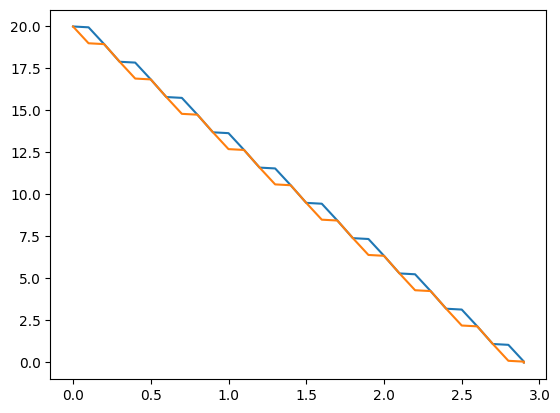

In [11]:
def gera_traco(declare, init, trans, k):
  Velocidades_Carro = []
  Velocidades_Rodas = []
  Tempos = []
  s = Solver()
  traco = [declare(i) for i in range(k)]
  s.add(init(traco[0]))
  for i in range(k-1):
    s.add(trans(traco[i], traco[i+1]))
  if s.check() == sat:
    m = s.model()
    for i in range(k):
      print("Estado:", i)
      modeloV = m[traco[i]['vcorpo']]
      modelov = m[traco[i]['vrodas']]
      modelot = m[traco[i]['t']]
      Velocidades_Carro.append(float(modeloV.numerator_as_long())/float(modeloV.denominator_as_long()))
      Velocidades_Rodas.append(float(modelov.numerator_as_long())/float(modelov.denominator_as_long()))
      Tempos.append(float(modelot.numerator_as_long())/float(modelot.denominator_as_long()))
      for v in traco[i]:
        res = m[traco[i][v]]
        if res.sort() != RealSort():
          print(v, '=', res)
        else:
          print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
      print()
    plt.plot(Tempos, Velocidades_Carro, Tempos, Velocidades_Rodas)
  else:
    print("Não tem solução.")


gera_traco(declare, init, trans, 74)

## Exercício 1.4

In [14]:
def invariante(curr,prox):
  i1 = Implies(prox['t'] > curr['t'], prox['vcorpo'] < curr['vcorpo'])  # PERDE VEL AO LONGO DO TEMPO
  i2 = Implies(prox['t'] > curr['t'], prox['vrodas'] < curr['vrodas'])
  i3 = curr['vcorpo'] >= curr['vrodas']

  return And(i1,i2,i3)

In [15]:
def bmc_always(declare,init,trans,inv,K):
  for k in range(2,K+1):
    s = Solver()
    traco = [declare(i) for i in range(k)]
    s.add(init(traco[0]))
    for i in range(k-1):
      s.add(trans(traco[i], traco[i+1]))

    s.add(Not(inv(traco[k-2], traco[k-1])))

    if s.check() == sat:
      m = s.model()
      for i in range(k):
        print(f"{k}Estado:", i)
        for v in traco[i]:
          res = m[traco[i][v]]
          if res.sort() != RealSort():
            print(v, '=', res)
          else:
            print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
      return
  return "A propriedade é válida para traços de tamanho até " + str(K)

bmc_always(declare,init,trans,invariante, 70)

'A propriedade é válida para traços de tamanho até 70'

Queremos mostrar que o programa atingue, em algum momento o modo "STOPPED". Pela defenição do automato e, baseado no enunciado, chegamos rápidamente à conclusão que, o resultado é valido se no ultimo estado, o modo for "STOPPED", pois este modo é o estado terminal do automato.

Assim, basta provar que a ultima iteração de estados resulta em modo "STOPPED".

In [30]:
def verificaStop(declare, init, trans, k):
  s = Solver()
  traco = [declare(i) for i in range(k)]
  s.add(init(traco[0]))
  for i in range(k-1):
    s.add(trans(traco[i], traco[i+1]))
  if s.check() == sat:
    m = s.model()
    res = m[traco[-1]['m']]
    if str(res) == 'STOPPED':
      print("A propriedade é valida, o modo do ultimo estado e:",res)

verificaStop(declare,init,trans,70)

A propriedade é valida, o modo do ultimo estado e: STOPPED
